In [ ]:
CMLS 2023 - Fab Four - Group ID: 6 - Python implementation of a continuous blendable multimode filter

In [1]:
import math

class Filter:
    def __init__(self):
        self.self_osc_push = False
        self.band_pass_sw = False
        self.mm = 0
        self.s1 = self.s2 = self.s3 = self.s4 = 0
        self.sample_rate = 44100
        self.sample_rate_inv = 1 / self.sample_rate
        rcrate = math.sqrt((44100 / self.sample_rate))
        self.rcor = (500.0 / 44100) * rcrate
        self.rcor24 = (970.0 / 44100) * rcrate
        self.rcor_inv = 1 / self.rcor
        self.rcor24_inv = 1 / self.rcor24
        self.R = 1
        self.R24 = 0

    def set_multimode(self, m):
        self.mm = m
        self.mmch = int(self.mm * 3)
        self.mmt = self.mm * 3 - self.mmch

    def set_sample_rate(self, sr):
        self.sample_rate = sr
        self.sample_rate_inv = 1 / self.sample_rate
        rcrate = math.sqrt((44100 / self.sample_rate))
        self.rcor = (500.0 / 44100) * rcrate
        self.rcor24 = (970.0 / 44100) * rcrate
        self.rcor_inv = 1 / self.rcor
        self.rcor24_inv = 1 / self.rcor24

    def set_resonance(self, res):
        self.R = 1 - res
        self.R24 = 3.5 * res

    def diode_pair_resistance_approx(self, x):
        # Taylor approximation of slightly mismatched diode pair
        return (((((0.0103592 * x + 0.00920833) * x + 0.185) * x + 0.05) * x + 1.0))

    def nr(self, sample, g):
        # Calculating feedback non-linear transconductance and compensated for R (-1)
        # Boosting non-linearity
        if not self.self_osc_push:
            t_cfb = self.diode_pair_resistance_approx(self.s1 * 0.0876) - 1.0
        else:
            t_cfb = self.diode_pair_resistance_approx(self.s1 * 0.0876) - 1.035

        # Resolve linear feedback
        y = ((sample - 2 * (self.s1 * (self.R + t_cfb)) - g * self.s1 - self.s2) / (1 + g * (2 * (self.R + t_cfb) + g)))

        return y

    def apply(self, sample, g):
        gpw = math.tan(g * self.sample_rate_inv * math.pi)
        g = gpw
        v = self.nr(sample, g)

        y1 = v * g + self.s1
        self.s1 = v * g + y1

        y2 = y1 * g + self.s2
        self.s2 = y1 * g + y2

        if not self.band_pass_sw:
            mc = (1 - self.mm) * y2 + (self.mm) * v
        else:
            if self.mm < 0.5:
                mc = 2 * ((0.5 - self.mm) * y2 + (self.mm) * y1)
            else:
                mc = 2 * ((1 - self.mm) * y1 + (self.mm - 0.5) * v)
        return mc

    def nr24(self, sample, g, lpc):
        ml = 1 / (1 + g)
        S = (lpc * (lpc * (lpc * self.s1 + self.s2) + self.s3) + self.s4) * ml
        G = lpc * lpc * lpc * lpc
        y = (sample - self.R24 * S) / (1 + self.R24 * G)
        return y

    def apply4pole(self, sample, g):
        g1 = math.tan(g * self.sample_rate_inv * math.pi)
        g = g1

        lpc = g / (1 + g)
        y0 = self.nr24(sample, g, lpc)
        v = (y0 - self.s1) * lpc
        res = v + self.s1
        self.s1 = res + v
        self.s1 = math.atan(self.s1 * self.rcor24) * self.rcor24_inv

        y1 = res
        y2 = (y1 - self.s2) * lpc
        self.s2 = y1 * lpc + self.s2

        y3 = (y2 - self.s3) * lpc
        self.s3 = y2 * lpc + self.s3

        y4 = (y3 - self.s4) * lpc
        self.s4 = y3 * lpc + self.s4

        if self.mmch == 0:
            mc = ((1 - self.mmt) * y4 + (self.mmt) * y3)
        elif self.mmch == 1:
            mc = ((1 - self.mmt) * y3 + (self.mmt) * y2)
        elif self.mmch == 2:
            mc = ((1 - self.mmt) * y2 + (self.mmt) * y1)
        elif self.mmch == 3:
            mc = y1
        else:
            mc = 0

        # Half volume compensation
        return mc * (1 + self.R24 * 0.45)



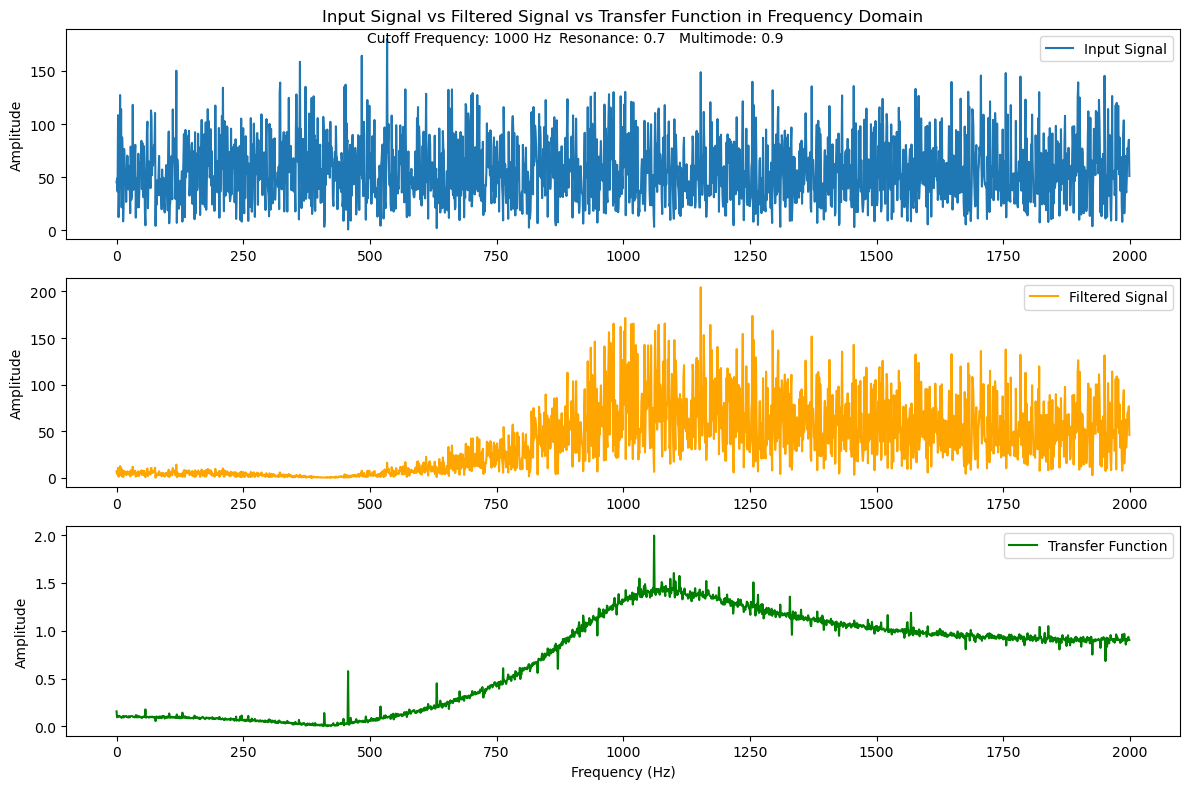

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

sample_rate = 4000
duration = 1  # 1 second
cutoff_freq = 1000  # Cutoff frequency of the filter (Hz)
resonance = 0.7
mm = 0.9 # 0: low-pass, 0.5: band-pass, 1: high-pass

# Generate white noise
input_signal = np.random.normal(0, 1, sample_rate * duration)

# Create a filter object
flt = Filter()

# Set the filter parameters
flt.set_sample_rate(sample_rate)
flt.set_resonance(resonance)
flt.set_multimode(mm)  

# Process the input signal through the filter
output_signal = np.zeros_like(input_signal)
for i, sample in enumerate(input_signal):
    output_signal[i] = flt.apply(sample, cutoff_freq)

# Compute the Fourier transforms and frequencies of the input and output signals
input_fft = fft(input_signal)
output_fft = fft(output_signal)
frequencies = np.fft.fftfreq(len(input_fft), 1 / sample_rate)

# Compute the transfer function (output_fft / input_fft)
transfer_function = np.abs(output_fft / input_fft)

# Plot the input and output signals in the frequency domain and the transfer function
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(frequencies[:sample_rate // 2], np.abs(input_fft)[:sample_rate // 2], label="Input Signal")
plt.legend()
plt.ylabel("Amplitude")
plt.title("Input Signal vs Filtered Signal vs Transfer Function in Frequency Domain")

plt.subplot(3, 1, 2)
plt.plot(frequencies[:sample_rate // 2], np.abs(output_fft)[:sample_rate // 2], label="Filtered Signal", color="orange")
plt.legend()
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(frequencies[:sample_rate // 2], transfer_function[:sample_rate // 2], label="Transfer Function", color="green")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.tight_layout()

plt.figtext(0.31, 0.94, f'Cutoff Frequency: {cutoff_freq} Hz', fontsize=10, ha='left')
plt.figtext(0.47, 0.94, f'Resonance: {resonance}', fontsize=10, ha='left')
plt.figtext(0.57, 0.94, f'Multimode: {multimode}', fontsize=10, ha='left')

plt.show()
